### Data Analysis

@Authors: [Franck Porteous](https://github.com/FranckPrts), [Faith Hunja](https://github.com/faithhunja), [Hannah Krohn](https://github.com/hlili303)

### Set-up

#### Imports

In [111]:
# Imports

import matplotlib.pyplot as plt
import xarray as xr
import os
import pooch
import tempfile
from pooch import HTTPDownloader
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
from cartopy import crs as ccrs
from scipy import stats
from scipy.stats import pearsonr

### Accessing the data

#### Get satellite data

In [112]:
event_to_process = "Maria"
locations_to_process = ["Isabel Segunda, PR (precise)", "Esperanza, PR (precise)", "Arecibo, PR (precise)", "Mayaguez, PR (precise)", "Fajardo, PR (precise)"]


In [113]:
### FOR THE DS

ds_allLoc_allEvent_ec = {}
ds_allLoc_allEvent_ec[event_to_process] = {}

for i in locations_to_process:
    print(f"doing {i[:-10]}")
    ds_loc = {}
    ds_loc[i[:-10]] = xr.open_dataset(f"./isp_saved_ds/ECCO_{i[:-10]}.nc") 
    
    # Add the current ds_loc to the ds_allLoc_allEvent_ec[event_to_process] dictionary
    ds_allLoc_allEvent_ec[event_to_process][i[:-10]] = ds_loc[i[:-10]]

print("> all datasets loaded")

doing Isabel Segunda, PR
doing Esperanza, PR
doing Arecibo, PR
doing Mayaguez, PR
doing Fajardo, PR
> all datasets loaded


In [114]:
ds_allLoc_allEvent_ec[event_to_process].keys()

dict_keys(['Isabel Segunda, PR', 'Esperanza, PR', 'Arecibo, PR', 'Mayaguez, PR', 'Fajardo, PR'])

In [115]:
### FOR THE ARRAYS

ar_allLoc_allEvent_ec = {}
ar_allLoc_allEvent_ec[event_to_process] = {}

for i in locations_to_process:
    print(f"doing {i[:-10]}")
    ar_loc = {}
    ar_loc[i[:-10]] = np.load(f"./isp_saved_arrays/ECCO_{event_to_process}-{i[:-10]}.npy") 
    
    # Add the current ds_loc to the ds_allLoc_allEvent_ec[event_to_process] dictionary
    ar_allLoc_allEvent_ec[event_to_process][i[:-10]] = ar_loc[i[:-10]]

print("> all ar loaded")

doing Isabel Segunda, PR
doing Esperanza, PR
doing Arecibo, PR
doing Mayaguez, PR
doing Fajardo, PR
> all ar loaded


#### Get tidal gauge data

In [116]:
ar_allLoc_allEvent_tg = {} #array
ds_allLoc_allEvent_tg = {} #dataset

# Setting up empty dicts for each event outside the loop
ar_allLoc_allEvent_tg[event_to_process] = {}
ds_allLoc_allEvent_tg[event_to_process] = {}

for lo in locations_to_process: 
    print(f'doing: {event_to_process} - {lo}')

    ar_allLoc_allEvent_tg[event_to_process][lo[:-10]] = np.load(f"./isp_saved_arrays/TG_{event_to_process}-{lo[:-10]}.npy")
    ds_allLoc_allEvent_tg[event_to_process][lo[:-10]] = xr.open_dataset(f"./saved_ds/{lo[:-10]}_TG.nc")

print("> all ds & array loaded")

doing: Maria - Isabel Segunda, PR (precise)
doing: Maria - Esperanza, PR (precise)
doing: Maria - Arecibo, PR (precise)
doing: Maria - Mayaguez, PR (precise)
doing: Maria - Fajardo, PR (precise)
> all ds & array loaded


## Analysis

In [228]:
loc_to_process = locations_to_process[0][:-10]
loc_to_process

'Isabel Segunda, PR'

### Analysis for satellite data

#### Find the rolling mean for satellite data

In [229]:
ds_m_avg_sat = ds_allLoc_allEvent_ec[event_to_process][loc_to_process].SSH.rolling(time=1000, min_periods=1, center=True).mean()

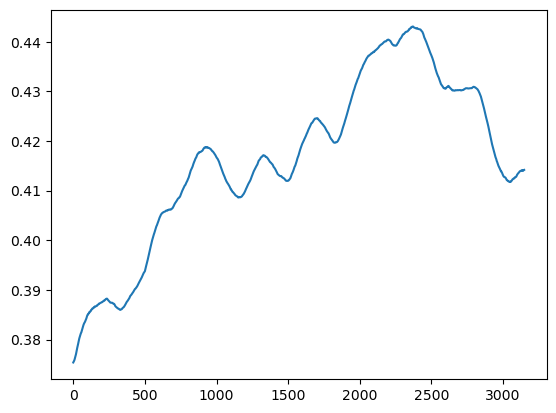

In [230]:
plt.plot(ds_m_avg_sat)

#### Find the rolling standard deviation for satellite data

In [231]:
ds_m_std_sat = ds_allLoc_allEvent_ec[event_to_process][loc_to_process].SSH.rolling(time=1000, min_periods=1, center=True).std()
ds_m_std_sat

<xarray.DataArray 'SSH' (time: 3149)>
array([0.04314934, 0.04314598, 0.0431226 , ..., 0.04200208, 0.04204106,
       0.04208098], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2009-03-07T12:00:00 ... 2017-10-19T12:00:00
    latitude   float32 ...
    longitude  float32 ...
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              -2.4861555099487305
    valid_max:              2.287546157836914

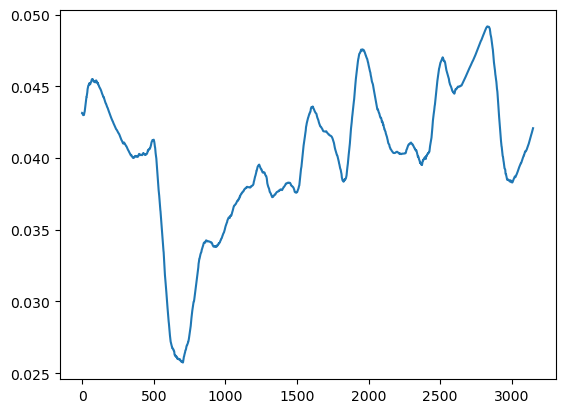

In [232]:
plt.plot(ds_m_std_sat)

### Analysis for tidal gauge data

#### Find the rolling mean for tidal gauge data

In [233]:
ds_m_avg_tg = ds_allLoc_allEvent_tg[event_to_process][loc_to_process].sea_level.rolling(time=1000, min_periods=1, center=True).mean()
ds_m_avg_tg = ds_m_avg_tg / 1000

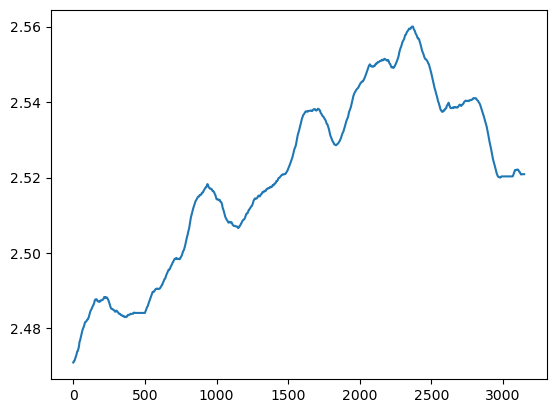

In [234]:
plt.plot(ds_m_avg_tg.values.flatten())

#### Find the rolling standard deviation for tidal gauge data

In [235]:
ds_m_std_tg = ds_allLoc_allEvent_tg[event_to_process][loc_to_process].sea_level.rolling(time=1000, min_periods=1, center=True).std()
ds_m_std_tg = ds_m_std_tg / 1000
ds_m_std_tg

<xarray.DataArray 'sea_level' (record_id: 1, time: 3149)>
array([[0.05794527, 0.05793522, 0.05789875, ..., 0.05374051, 0.05374051,
        0.05374051]], dtype=float32)
Coordinates:
  * record_id  (record_id) int16 7321
  * time       (time) datetime64[ns] 2009-03-07 2009-03-08 ... 2017-10-19

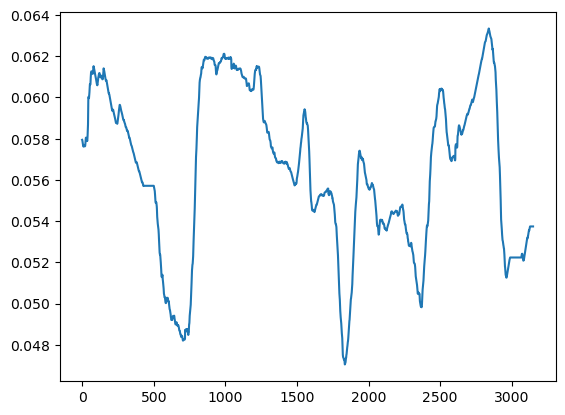

In [236]:
plt.plot(ds_m_std_tg.values.flatten())

### Correlation of rolling mean between satellite and tidal gauge data

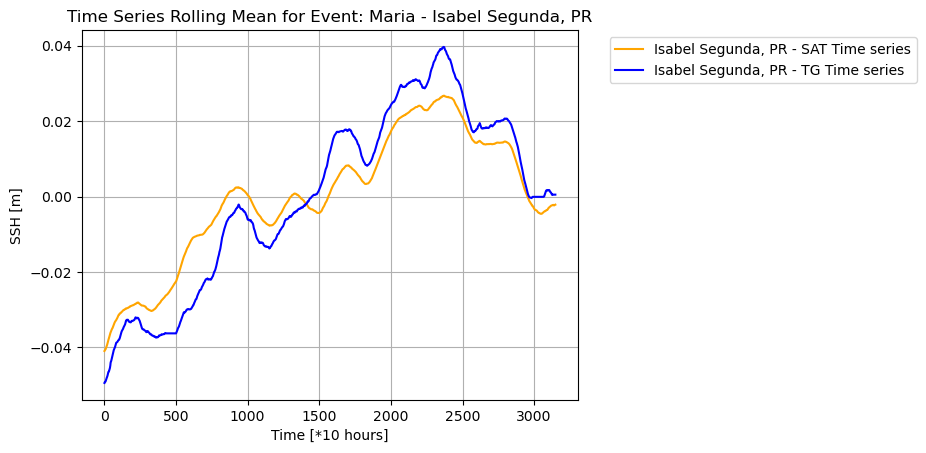

In [237]:
ds_m_avg_sat_normalized = ds_m_avg_sat - ds_m_avg_sat.mean()
ds_m_avg_tg_normalized = ds_m_avg_tg - ds_m_avg_tg.mean()

plt.plot(ds_m_avg_sat_normalized, color='orange', label=f'{loc_to_process} - SAT Time series') 
plt.plot(ds_m_avg_tg_normalized.values.flatten(), color='blue', label=f'{loc_to_process} - TG Time series') 
  
plt.xlabel("Time [*10 hours]") 
plt.ylabel("SSH [m]") 
plt.title(f"Time Series Rolling Mean for Event: {event_to_process} - {loc_to_process}") 

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(True)

figure_dir = './isp_figures/'
os.makedirs(figure_dir, exist_ok=True)

plot_filename = f'rolling_mean_{event_to_process}_{loc_to_process}.png'
plt.savefig(os.path.join(figure_dir, plot_filename), bbox_inches='tight')

plt.show() 

In [238]:
(ds_m_avg_sat_normalized.shape[0], ds_m_avg_tg_normalized.values.flatten().shape[0])

(3149, 3149)

In [239]:
def make_arrays_same_length(arr1, arr2):
    len1, len2 = len(arr1), len(arr2)

    if len1 != len2:
        min_len = min(len1, len2)
        arr1 = arr1[:min_len]
        arr2 = arr2[:min_len]

    return arr1, arr2

In [240]:
corr_val_ds_ec = ds_m_avg_sat_normalized
corr_val_ds_tg = ds_m_avg_tg_normalized.values.flatten()

corr_val_ds_ec, corr_val_ds_tg = make_arrays_same_length(corr_val_ds_ec, corr_val_ds_tg)

correlation_coefficient, p_value = pearsonr(corr_val_ds_ec, corr_val_ds_tg)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.9718327710422134
P-value: 0.0


### Correlation of rolling std between satellite and tidal gauge data

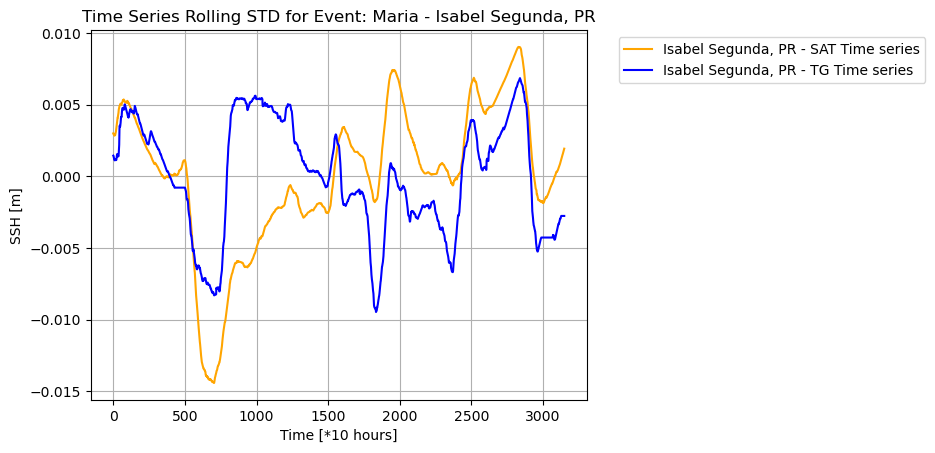

In [241]:
ds_m_std_sat_normalized = ds_m_std_sat - ds_m_std_sat.mean()
ds_m_std_tg_normalized = ds_m_std_tg - ds_m_std_tg.mean()

plt.plot(ds_m_std_sat_normalized, color='orange', label=f'{loc_to_process} - SAT Time series') 
plt.plot(ds_m_std_tg_normalized.values.flatten(), color='blue', label=f'{loc_to_process} - TG Time series') 
  
plt.xlabel("Time [*10 hours]") 
plt.ylabel("SSH [m]")
plt.title(f"Time Series Rolling STD for Event: {event_to_process} - {loc_to_process}") 
  
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(True)

figure_dir = './isp_figures/'
os.makedirs(figure_dir, exist_ok=True)

plot_filename = f'rolling_std_{event_to_process}_{loc_to_process}.png'
plt.savefig(os.path.join(figure_dir, plot_filename), bbox_inches='tight')

plt.show() 

In [242]:
# Compute Pearson correlation coefficient and p-value
corr_val_ds_ec = ds_m_std_sat_normalized
corr_val_ds_tg = ds_m_std_tg_normalized.values.flatten()

corr_val_ds_ec, corr_val_ds_tg = make_arrays_same_length(corr_val_ds_ec, corr_val_ds_tg)

correlation_coefficient, p_value = pearsonr(corr_val_ds_ec, corr_val_ds_tg)

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.3865297618168296
P-value: 9.630575093800546e-113


### Correlation of entire time series between satellite and tidal gauge data

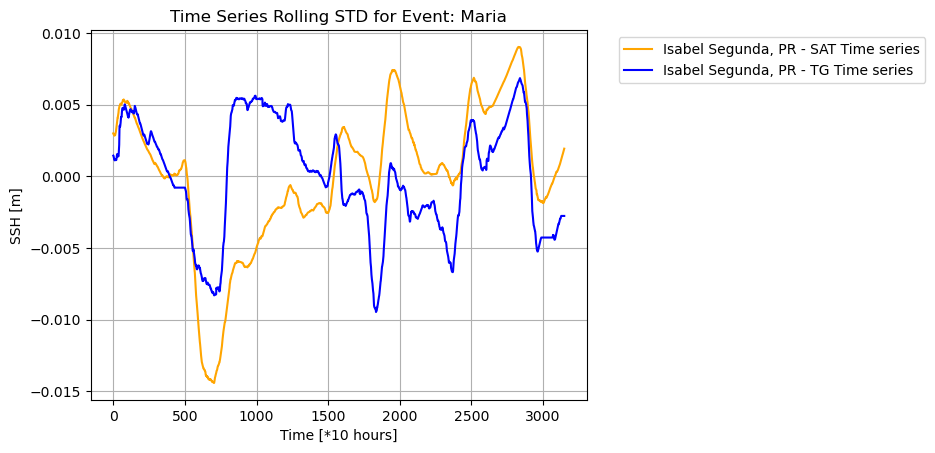

In [243]:
ds_m_std_sat_normalized = ds_m_std_sat - ds_m_std_sat.mean()
ds_m_std_tg_normalized = ds_m_std_tg - ds_m_std_tg.mean()

plt.plot(ds_m_std_sat_normalized, color='orange', label=f'{loc_to_process} - SAT Time series') 
plt.plot(ds_m_std_tg_normalized.values.flatten(), color='blue', label=f'{loc_to_process} - TG Time series') 
  
plt.xlabel("Time [*10 hours]") 
plt.ylabel("SSH [m]")
plt.title(f"Time Series Rolling STD for Event: {event_to_process}") 

figure_dir = './isp_figures/'
os.makedirs(figure_dir, exist_ok=True)

plot_filename = f'fullTimeSerie_std_{event_to_process}_{loc_to_process}.png'
plt.savefig(os.path.join(figure_dir, plot_filename), bbox_inches='tight')
  
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(True)
plt.show() 

In [244]:
# Compute Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(ds_m_std_sat, ds_m_std_tg.values.flatten())

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.3865297618168296
P-value: 9.630575093800546e-113
